In [1]:
import os
import random
import pandas as pd

# 상위 폴더 경로 설정
ROOT_DIR = r'C:\workspace\dataset\train'

# 하위 폴더 수집
folders = [os.path.join(ROOT_DIR, d) for d in os.listdir(ROOT_DIR) if os.path.isdir(os.path.join(ROOT_DIR, d))]

# 폴더별 wav 파일 매핑
folder_to_files = {}
for folder in folders:
    wavs = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.wav')]
    if len(wavs) >= 2:
        folder_to_files[folder] = wavs

positive_pairs = []
negative_pairs = []
all_pairs_set = set()

# 동일 폴더 내 쌍 (positive): 12,000개
while len(positive_pairs) < 12_000:
    folder = random.choice(list(folder_to_files.keys()))
    files = folder_to_files[folder]
    f1, f2 = random.sample(files, 2)
    if f1 != f2:
        key = tuple(sorted((f1, f2)))
        if key not in all_pairs_set:
            all_pairs_set.add(key)
            positive_pairs.append((f1, f2, 1))

# 서로 다른 폴더 간 쌍 (negative): 24,000개
folder_keys = list(folder_to_files.keys())
while len(negative_pairs) < 24_000:
    folder1, folder2 = random.sample(folder_keys, 2)
    f1 = random.choice(folder_to_files[folder1])
    f2 = random.choice(folder_to_files[folder2])
    if f1 != f2:
        key = tuple(sorted((f1, f2)))
        if key not in all_pairs_set:
            all_pairs_set.add(key)
            negative_pairs.append((f1, f2, 0))

# 전체 쌍 합치고 무작위 셔플
all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)

# 학습/테스트 분리
train_pairs = all_pairs[:30_000]
test_pairs = all_pairs[30_000:]

# DataFrame 생성 및 저장
train_df = pd.DataFrame(train_pairs, columns=['f1', 'f2', 'label'])
test_df = pd.DataFrame(test_pairs, columns=['f1', 'f2', 'label'])

train_df.to_csv('train_pairs.csv', index=False)
test_df.to_csv('test_pairs_self.csv', index=False)

print(f"✅ 학습셋: {len(train_df)}쌍 → train_pairs.csv")
print(f"✅ 테스트셋: {len(test_df)}쌍 → test_pairs_self.csv")


✅ 학습셋: 30000쌍 → train_pairs.csv
✅ 테스트셋: 6000쌍 → test_pairs_self.csv


In [2]:
# 상위 폴더 경로 설정
ROOT_DIR = r'C:\workspace\dataset\test'

# 하위 폴더 수집
folders = [os.path.join(ROOT_DIR, d) for d in os.listdir(ROOT_DIR) if os.path.isdir(os.path.join(ROOT_DIR, d))]

# 폴더별 wav 파일 매핑
folder_to_files = {}
for folder in folders:
    wavs = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.wav')]
    if len(wavs) >= 2:
        folder_to_files[folder] = wavs

positive_pairs = []
negative_pairs = []
all_pairs_set = set()

# 동일 폴더 내 쌍 (positive): 2,000개
while len(positive_pairs) < 3_000:
    folder = random.choice(list(folder_to_files.keys()))
    files = folder_to_files[folder]
    f1, f2 = random.sample(files, 2)
    if f1 != f2:
        key = tuple(sorted((f1, f2)))
        if key not in all_pairs_set:
            all_pairs_set.add(key)
            positive_pairs.append((f1, f2, 1))

# 서로 다른 폴더 간 쌍 (negative): 4,000개
folder_keys = list(folder_to_files.keys())
while len(negative_pairs) < 7_000:
    folder1, folder2 = random.sample(folder_keys, 2)
    f1 = random.choice(folder_to_files[folder1])
    f2 = random.choice(folder_to_files[folder2])
    if f1 != f2:
        key = tuple(sorted((f1, f2)))
        if key not in all_pairs_set:
            all_pairs_set.add(key)
            negative_pairs.append((f1, f2, 0))

# 전체 쌍 합치고 무작위 셔플
all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)

# DataFrame 생성 및 저장
test_df = pd.DataFrame(all_pairs, columns=['f1', 'f2', 'label'])

test_df.to_csv('test_pairs.csv', index=False)

print(f"✅ 테스트셋: {len(test_df)}쌍 → test_pairs.csv")


✅ 테스트셋: 10000쌍 → test_pairs.csv


In [3]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [1]:
import os
import random
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



# --------------------------
# 설정
# --------------------------
SAMPLE_RATE = 16000
DURATION = 10  # seconds
NUM_SAMPLES = SAMPLE_RATE * DURATION


# --------------------------
# 데이터 로딩 및 전처리
# --------------------------
def load_wav(filepath):
    audio = tf.audio.decode_wav(tf.io.read_file(filepath), desired_channels=1).audio
    audio = tf.squeeze(audio, axis=-1)  # shape: [samples]
    num_samples = tf.shape(audio)[0]

    # 길이 보정
    audio = tf.cond(
        num_samples < NUM_SAMPLES,
        lambda: tf.pad(audio, [[0, NUM_SAMPLES - num_samples]]),
        lambda: audio[:NUM_SAMPLES]
    )

    return audio.numpy()


class CachedWavPairDataset(tf.keras.utils.Sequence):
    def __init__(self, csv_path, batch_size=32, shuffle=True):
        self.df = pd.read_csv(csv_path)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        
        # wav 파일을 메모리에 미리 로드
        self.wav_cache = {}
        # f1, f2 컬럼의 모든 경로 리스트 만들기
        all_files = set(self.df['f1']).union(set(self.df['f2']))
        
        for fpath in all_files:
            self.wav_cache[fpath] = load_wav(fpath)
        
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.df) // self.batch_size
    
    def __getitem__(self, idx):
        indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch = self.df.iloc[indices]
        
        X = []
        y = []
        for _, row in batch.iterrows():
            f1 = self.wav_cache[row['f1']]
            f2 = self.wav_cache[row['f2']]
            pair = np.stack([f1, f2], axis=-1)  # (160000, 2)
            X.append(pair)
            y.append(row['label'])
        
        X = np.stack(X)
        y = np.array(y).astype(np.float32)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# --------------------------
# 모델 정의 (CNN)
# --------------------------
def create_model():
    inputs = tf.keras.Input(shape=(NUM_SAMPLES, 2))  # (160000, 2)
    
    x = tf.keras.layers.Conv1D(128, kernel_size=5, strides=2, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)


    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model


# --------------------------
# 학습 실행
# --------------------------
def train_model(train_csv, test_csv, batch_size=16, epochs=10):
    train_data = CachedWavPairDataset(train_csv, batch_size=batch_size)
    test_data = CachedWavPairDataset(test_csv, batch_size=batch_size, shuffle=False)

    model = create_model()
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',     # 기준 지표
        factor=0.5,             # 줄이는 비율 (학습률 *= 0.5)
        patience=3,             # 향상 없을 경우 몇 epoch 기다릴지
        verbose=1,              # 출력 여부
        min_lr=1e-6             # 학습률 최소값 제한
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',      # 감시할 값 (val_accuracy도 가능)
        patience=7,              # 개선이 없을 경우 기다릴 에포크 수
        restore_best_weights=True  # 가장 좋은 weight로 복원
    )

    history = model.fit(train_data, validation_data=test_data, epochs=epochs, shuffle=True, verbose=2, callbacks=[reduce_lr, early_stopping])

    # 메모리 캐시된 WAV 삭제
    del train_data.wav_cache
    del test_data.wav_cache
    import gc
    gc.collect()

    return model, history


In [2]:
import matplotlib.pyplot as plt

# 손실 함수 시각화
def plot_loss_curve(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
# 정확도 시각화
def plot_accuracy_curve(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

#컨퓨전 매트릭스
def plot_confusion_matrix_binary(model, dataset, class_names=['Different', 'Same']):
    y_true = []
    y_pred = []

    for X_batch, y_batch in dataset:
        preds = model.predict(X_batch)
        preds = (preds > 0.5).astype(int)  # threshold 적용
        y_pred.extend(preds.flatten())
        y_true.extend(y_batch.astype(int))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


In [5]:
#모델 학습
model, model_history = train_model('train_pairs.csv', 'test_pairs.csv', batch_size=8, epochs=60)

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()


Epoch 1/60
3750/3750 - 330s - loss: 0.5246 - accuracy: 0.7053 - val_loss: 0.5260 - val_accuracy: 0.7259 - lr: 0.0010 - 330s/epoch - 88ms/step
Epoch 2/60
3750/3750 - 327s - loss: 0.4977 - accuracy: 0.7266 - val_loss: 0.5156 - val_accuracy: 0.7408 - lr: 0.0010 - 327s/epoch - 87ms/step
Epoch 3/60
3750/3750 - 327s - loss: 0.4699 - accuracy: 0.7555 - val_loss: 0.5387 - val_accuracy: 0.6941 - lr: 0.0010 - 327s/epoch - 87ms/step
Epoch 4/60
3750/3750 - 328s - loss: 0.4130 - accuracy: 0.8089 - val_loss: 0.4924 - val_accuracy: 0.7619 - lr: 0.0010 - 328s/epoch - 87ms/step
Epoch 5/60
3750/3750 - 328s - loss: 0.3808 - accuracy: 0.8272 - val_loss: 0.9260 - val_accuracy: 0.7073 - lr: 0.0010 - 328s/epoch - 87ms/step
Epoch 6/60
3750/3750 - 328s - loss: 0.3566 - accuracy: 0.8423 - val_loss: 0.4351 - val_accuracy: 0.8021 - lr: 0.0010 - 328s/epoch - 87ms/step
Epoch 7/60
3750/3750 - 328s - loss: 0.3388 - accuracy: 0.8495 - val_loss: 1.1666 - val_accuracy: 0.6922 - lr: 0.0010 - 328s/epoch - 87ms/step
Epoch 

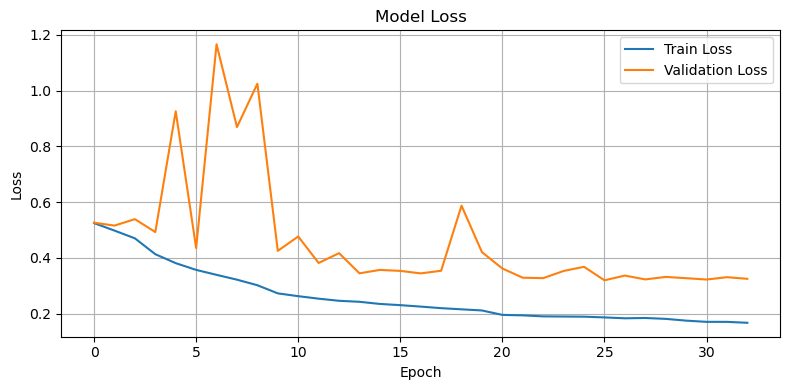

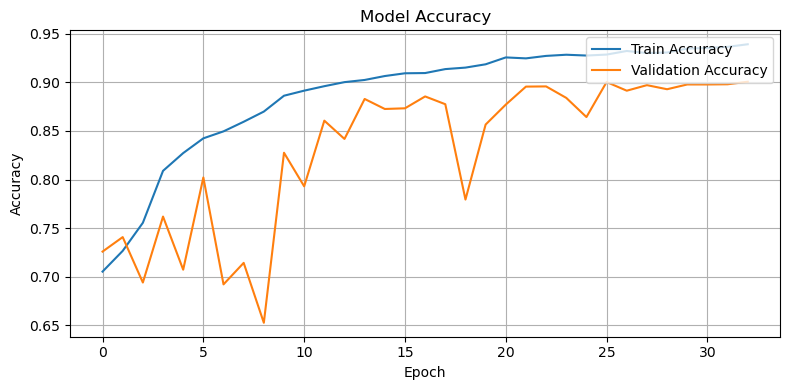

1/1 [==============================] - 0s 9ms/step


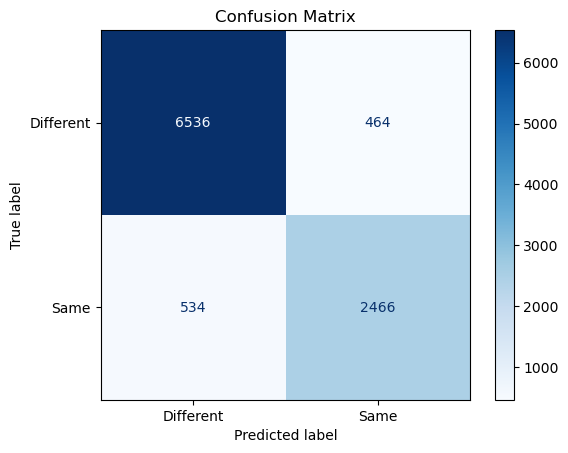

In [6]:
#손실 함수 표현
plot_loss_curve(model_history)

#정확도 함수 표현
plot_accuracy_curve(model_history)

#컨퓨전 매트릭스 표현
test_data = CachedWavPairDataset('test_pairs.csv', batch_size=8, shuffle=False)
plot_confusion_matrix_binary(model, test_data, class_names=['Different', 'Same'])

In [ ]:
model_self = train_model('train_pairs.csv', 'test_pairs_self.csv', batch_size=16, epochs=10)

model_self.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model_self.summary()

In [ ]:
test_df